# **Kaggle Competition : Toxic comment classification**

Team : Nishtha KHURANA, Irene SUNNY 

Problem Statement:
We are given a dataset with comments from online platform. We have the challenge of classifying the comments as toxic(1) or non-toxic(0). 





**We are providing the code for the best 3 models which achieved high worst-group accuracy on the public dataset. We have ensembled the predictions based on weighted votes from the 3 models for the final prediction values.**

Loading Data

In [1]:
# # install PyTorch
# !pip install torch torchvision torchaud
# !pip install torch
# !pip install transformers

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm.notebook import tqdm
import torch
import numpy as np
import pandas as pd

In [4]:
# Assuming the files are in the "input/dl-kaggle" folder
train_x = pd.read_csv('/kaggle/input/dl-kaggle/train_x.csv')
train_y = pd.read_csv('/kaggle/input/dl-kaggle/train_y.csv')

# Check the first few rows of your training data
print(train_x.head())
print(train_y.head())

   index                                             string
0      0                         even up here.......BLACKS!
1      1  Blame men.  There's always an excuse to blame ...
2      2  You have no business making any comments on th...
3      3  "Let's get the black folks and the white folks...
4      4  I guess the issue is people not willing to put...
   male  female  LGBTQ  christian  muslim  other_religions  black  white  \
0     0       0      0          0       0                0      1      0   
1     1       1      0          0       0                0      0      0   
2     0       0      0          0       0                0      0      0   
3     0       0      0          0       0                0      1      1   
4     0       0      0          0       0                0      0      0   

   identity_any  severe_toxicity  obscene  threat  insult  identity_attack  \
0             1                0        0       0       0                1   
1             1            

In [5]:
# Load your validation and test sets if you have them ready.
val_x = pd.read_csv('/kaggle/input/dl-kaggle/val_x.csv')
val_y = pd.read_csv('/kaggle/input/dl-kaggle/val_y.csv')

# Check the first few rows of training data
print(val_x.head())
print(val_y.head())

   index                                             string
0      0  Why is this black racist crap still on the G&M...
1      1  And the woman exposing herself saying grab thi...
2      2  You're a troll.\n\nYou're not 907AK.\n\nYou're...
3      3                        You sound like a terrorist.
4      4  When it all goes to crap, better to punch up i...
   male  female  LGBTQ  christian  muslim  other_religions  black  white  \
0     0       0      0          0       0                0      1      1   
1     0       1      0          0       0                0      0      0   
2     0       0      0          0       0                0      0      0   
3     0       0      0          0       0                0      0      0   
4     0       0      0          0       0                0      0      0   

   identity_any  severe_toxicity  obscene  threat  insult  identity_attack  \
0             1                0        0       0       1                1   
1             1            

In [6]:
# Load Test Data
test_x = pd.read_csv('/kaggle/input/dl-kaggle/test_x.csv')  # For the test set, no labels.

 # Check the first few rows of your training data
print(test_x.head())

   index                                             string
0      0  OH yes - Were those evil Christian Missionarie...
1      1  He's considered a good candidate for a cyber-s...
2      2  Lela, you admit no records exist to support yo...
3      3  I'll take the iffy libertarian over the guy wh...
4      4       Shouldn't your handle be Republic of Uranus?


**Explore and Verify Data**

In [7]:
# Display the first few entries of the training data and labels to understand their structure

# Check the size of the datasets
print("Training data: ", train_x.shape)
print("Training labels: ", train_y.shape)

# Check for any missing values in the datasets
print(train_x.isnull().sum())
print(train_y.isnull().sum())

Training data:  (269038, 2)
Training labels:  (269038, 17)
index     0
string    1
dtype: int64
male                  0
female                0
LGBTQ                 0
christian             0
muslim                0
other_religions       0
black                 0
white                 0
identity_any          0
severe_toxicity       0
obscene               0
threat                0
insult                0
identity_attack       0
sexual_explicit       0
y                     0
from_source_domain    0
dtype: int64


**Replace Null with Empty String**

In [9]:
print(type(train_x['string'].iloc[0]))
print(train_x['string'].isnull().sum())
print(val_x['string'].isnull().sum())
print(test_x['string'].isnull().sum())

<class 'str'>
0
0
0


In [ ]:
# Replace NaN values with an empty string
train_x['string'].fillna('', inplace=True)
# Replace NaN values with an empty string
val_x['string'].fillna('', inplace=True)
# Replace NaN values with an empty string
test_x['string'].fillna('', inplace=True)

Class Distribution - Train Y

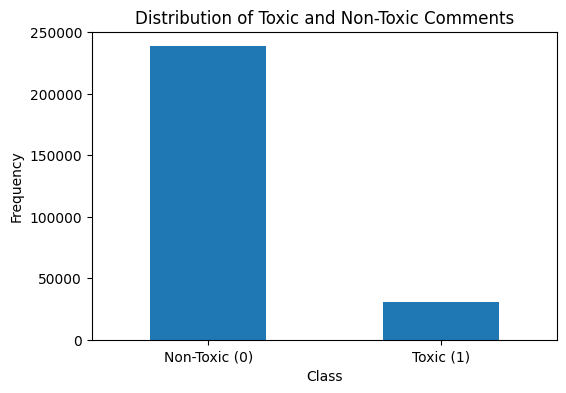

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_y is your DataFrame with the 'y' column for toxicity labels
# and train_X is your DataFrame with the identity columns

# Plot the distribution of the 'toxic' and 'non-toxic' classes
plt.figure(figsize=(6, 4))
train_y['y'].value_counts().plot(kind='bar')
plt.title('Distribution of Toxic and Non-Toxic Comments')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Non-Toxic (0)', 'Toxic (1)'], rotation=0)
plt.show()

Identity Distribution

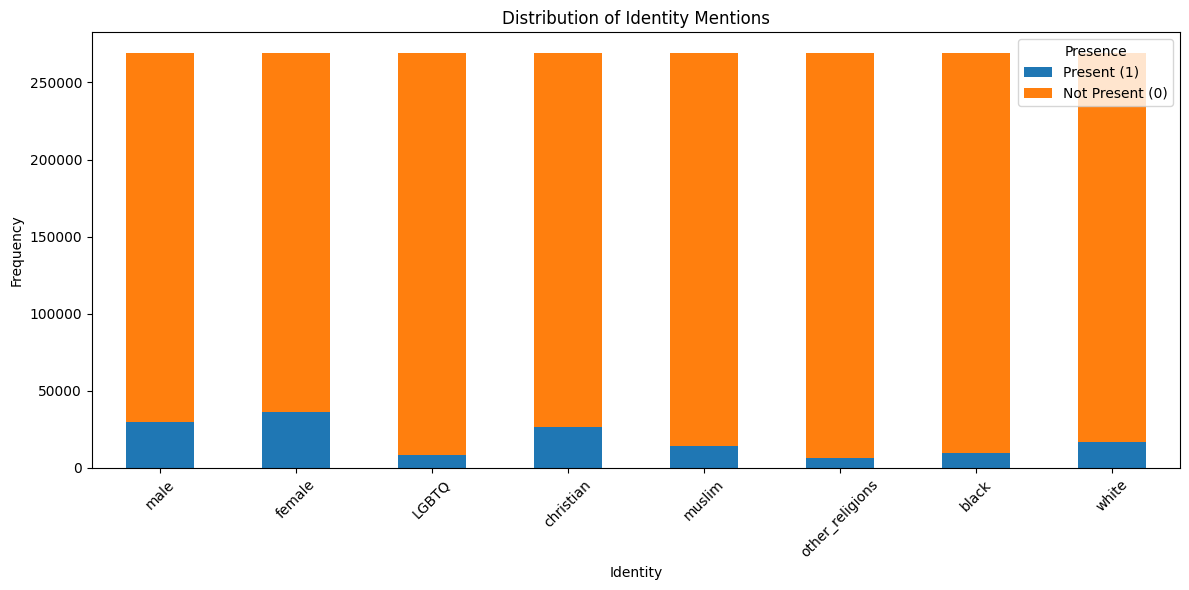

In [12]:
# Plot the distribution for each identity
identities = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

# Initialize a dictionary to hold the count data
identity_counts = {}

# Loop through each identity and count the presence and absence
for identity in identities:
    identity_present = train_y[identity].sum()
    identity_absent = (train_y[identity] == 0).sum()
    identity_counts[identity] = [identity_present, identity_absent]

# Convert the dictionary to a DataFrame for easier plotting
identity_counts_df = pd.DataFrame(identity_counts, index=['Present (1)', 'Not Present (0)'])

# Plotting the identity counts
identity_counts_df.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Identity Mentions')
plt.xlabel('Identity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Presence')
plt.tight_layout()  # Adjust the layout to make room for the x-labels
plt.show()

In [15]:
import plotly.express as px

# Assuming `train_X` is your actual DataFrame and you've calculated `identity_present_counts` as before:
identity_present_counts = train_y[identities].sum()

# Create interactive bar plot using Plotly
fig = px.bar(x=identity_present_counts.index, y=identity_present_counts.values, 
             labels={'x': 'Identity', 'y': 'Number of Comments'},
             title='Number of Comments with Identity Present')

# Customize hover data
fig.update_traces(hoverinfo='y+name')

fig.show()


### BERT Baseline model

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

**Preprocessing**

**Find out the maximum length of comment**

In [ ]:
# Example of calculating the length of each comment
comment_lengths = train_x['string'].apply(lambda x: len(tokenizer.tokenize(x)))

# Look at the distribution of comment lengths
print(comment_lengths.describe())

# Find the 95th percentile length
max_length = int(comment_lengths.quantile(0.95))

print(f"Chosen max_length: {max_length}")

#211 is the max_length


**1. Tokenizing the Dataset with BERT Tokenizer - Train Dataset**

In [ ]:
# Tokenize all comments in the train_x dataset
encoded_data_train = tokenizer.batch_encode_plus(
    train_x['string'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=230,
    return_tensors='pt'
)

# Extract the input IDs and attention masks
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']

**2. Tokenizing the Dataset with BERT Tokenizer - Val Dataset**

In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(
    val_x['string'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=230, #215
    return_tensors='pt'
)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

**3. Tokenizing the Dataset with BERT Tokenizer - Test Dataset**

In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_x['string'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=230,
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']

In [ ]:
# Assuming you don't have labels for test data
# Create a dummy tensor for indices (same length as input_ids_test)
dummy_indices = torch.arange(len(input_ids_test))

**Setup Necessary Columns and Create Tensor Data Set and Data Loader - Train**

In [ ]:
# Select identity columns and the 'y' label
identity_columns = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
relevant_columns = identity_columns + ['y']
train_y_relevant = train_y[relevant_columns]

In [ ]:
# Extract the binary target labels
labels_train = torch.tensor(train_y['y'].values)

In [ ]:
# Extract identity information
identity_info_train = train_y_relevant[identity_columns]

In [ ]:
# Create TensorDataset
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

# Create DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

# Create a dataset with input IDs, attention masks, labels, and indices
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val, torch.arange(len(labels_val)))

# Create a sequential sampler and dataloader
sampler_val = SequentialSampler(dataset_val)
dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=64)

# Now, the dataloader will yield batches in the form (input_ids, attention_masks, labels, indices)

**Setup Necessary Columns and Create Tensor Data Set and Data Loader - Val**

In [ ]:
val_y_relevant = val_y[relevant_columns]
labels_val = torch.tensor(val_y_relevant['y'].values)
identity_info_val = val_y_relevant[identity_columns]

In [ ]:
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataloader_val = DataLoader(dataset_val, batch_size=64)  # Use the same batch size as the training set

**Setup Necessary Columns and Create Tensor Data Set and Data Loader - Test**

In [ ]:
# Create TensorDataset for test data
dataset_test = TensorDataset(input_ids_test, attention_masks_test, dummy_indices)

# Set up a DataLoader for the test set
dataloader_test = DataLoader(dataset_test, batch_size=512, shuffle=False)  # Use the same batch size as the training set

## Define the BERT Model for Sequence Classification

In [ ]:
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)
# Move model to GPU or CPU
model.cuda()


In [ ]:
# Calculate class weights for handling class imbalance
class_weights = train_y['y'].value_counts(normalize=True)
weights = torch.tensor([1.0 - class_weights[0], 1.0 - class_weights[1]]).cuda()

In [ ]:
# Import the PyTorch AdamW optimizer
from torch.optim import AdamW

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weights)

## Training the BERT Model on Train Dataset

In [ ]:
# Set the number of training epochs
epochs = 4
best_train_loss = float('inf')
best_val_loss = float('inf')

# Create the learning rate scheduler
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Function to calculate the accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training loop
for epoch_i in range(epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    total_train_loss = 0
    total_train_accuracy = 0

    model.train()
    for step, batch in enumerate(tqdm(dataloader_train, desc='Batch', leave=False)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_loss += loss.item()
        total_train_accuracy += flat_accuracy(logits, label_ids)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader_train)
    avg_train_accuracy = total_train_accuracy / len(dataloader_train)
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {avg_train_accuracy:.2f}")

    # Save the model if training loss decreases
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), 'best_model_train.pth')
        print("Best model saved based on training loss!")

    # Evaluate on validation set
    # The evaluate_model function needs to be defined elsewhere in your code
    val_loss, val_worst_group_accuracy, val_group_accuracies = evaluate_model(model, dataloader_val, criterion, device=device)
    print(f"Validation Loss: {val_loss:.2f}")
    print(f"Worst Group Accuracy: {val_worst_group_accuracy:.2f}")
    # ... Additional code to print group accuracies ...

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_val.pth')
        print("Best model saved based on validation loss!")

print("Training complete!")


In [ ]:
# Load the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Load the weights from the saved file directly to the GPU
model.load_state_dict(torch.load('/kaggle/input/bert-round-1-epoch3/best_model_3.pth', map_location=torch.device('cuda')))

# Move the model to GPU
model.to('cuda')

## **Evaluation Process**

**Evaluate the model on the validation dataset**

In [ ]:
def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga, accuracies


In [ ]:
# evaluate_model function
def evaluate_model(model, dataloader, labels, criterion, device='cuda'):
    model.eval()
    model.to(device)
    losses, predictions, indices = [], [], []

    for batch in tqdm(dataloader, leave=False):
        b_input_ids, b_input_mask, b_labels, idx = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
        
    pred = torch.sigmoid(logits)[:, 1]  # Shape: [batch_size]
    loss = criterion(pred, b_labels.float())  # Ensure b_labels is float for BCE loss

    losses.extend([loss.item()] * b_input_ids.size(0))
    predictions.extend(pred.detach().cpu().numpy())
    indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    wga, group_accuracies = worst_group_accuracy(pred_df.set_index('index'), labels)

    return dataset_loss, wga, group_accuracies

In [ ]:
# Define the criterion (loss function) 
criterion = torch.nn.BCEWithLogitsLoss()
# Assuming val_y is your DataFrame containing the validation labels and metadata
val_loss, val_worst_group_accuracy, group_accuracies = evaluate_model(model, dataloader_val, val_y, criterion, device='cuda')

# Print the results
print(f"Validation Loss: {val_loss:.2f}")
print(f"Worst Group Accuracy: {val_worst_group_accuracy:.2f}")

# Print accuracies for each group
categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
for i, category in enumerate(categories):
    print(f"{category}_true: {group_accuracies[2*i]:.2f}")
    print(f"{category}_false: {group_accuracies[2*i + 1]:.2f}")


## **Generate Classification on Test Dataset**

In [ ]:
model.eval()  # Set the model to evaluation mode
test_predictions, indices = [], []

# Iterate over batches in the test dataloader
for batch in tqdm(dataloader_test, leave=False):
    b_input_ids, b_input_mask, idx = batch

    # Move inputs to the device (GPU or CPU)
    b_input_ids = b_input_ids.to('cuda')
    b_input_mask = b_input_mask.to('cuda')

    with torch.no_grad():
        # Get model outputs (logits)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

    # Convert logits to probabilities and then to binary predictions
    # Assuming positive class is the second column (index 1)
    pred = torch.sigmoid(logits)[:, 1]  # Get probabilities for the positive class
    pred = (pred > 0.5).int()  # Convert to 0 or 1 based on threshold
    test_predictions.extend(pred.cpu().tolist())
    indices.extend(idx.cpu().tolist())


## **Create Submission File**

In [ ]:
# Create a DataFrame for submission
pred_df = pd.DataFrame({
    'ID': indices,
    'pred': test_predictions
})

# Save the DataFrame to a CSV file for submission
pred_df.to_csv('prediction_bert.csv', index=False)

## **BERT Fine-Tuned** 

**Addressing Underperformance of Black, White, LGBTQ+, Muslim,other Religions for under represented identities**

In [ ]:
# Assuming the files are in the "input/dl-kaggle" folder
train_x = pd.read_csv('/kaggle/input/dl-kaggle/train_x.csv')
train_y = pd.read_csv('/kaggle/input/dl-kaggle/train_y.csv')

# Load your validation and test sets if you have them ready.
val_x = pd.read_csv('/kaggle/input/dl-kaggle/val_x.csv')
val_y = pd.read_csv('/kaggle/input/dl-kaggle/val_y.csv')

test_x = pd.read_csv('/kaggle/input/dl-kaggle/test_x.csv')

In [ ]:
# Define a function for text cleaning
def clean_text(text):
    # Lowercasing
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    return text

# Apply the cleaning function to the 'string' column in each dataset
train_x['string'] = train_x['string'].apply(clean_text)
val_x['string'] = val_x['string'].apply(clean_text)
test_x['string'] = test_x['string'].apply(clean_text)

# Check the first few rows of your cleaned training data
print(train_x.head())

In [ ]:
# Helper function to calculate class weights for BCEWithLogitsLoss
def calculate_class_weights(targets):
    class_counts = targets.value_counts()
    total_samples = len(targets)
    class_weights = {label: total_samples / count for label, count in class_counts.items()}
    return torch.tensor(list(class_weights.values()), dtype=torch.float32)

In [ ]:
# Helper function to oversample underrepresented identities
def create_oversampled_dataloader(train_x, train_y, tokenizer, batch_size=32):
    # Assuming 'identity' is the column containing identity labels
    identities = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    
    oversampled_data = []
    for identity in identities:
        subset = train_x[train_x[identity] == 1]
        oversampled_data.append(subset)
    
    oversampled_data = pd.concat(oversampled_data, ignore_index=True)
    oversampled_labels = train_y.loc[oversampled_data.index]['target'].values
    
    # Tokenize oversampled data
    encoded_data_oversampled = tokenizer.batch_encode_plus(
        oversampled_data['string'].tolist(),
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=230,
        return_tensors='pt'
    )
    
    input_ids_oversampled = encoded_data_oversampled['input_ids']
    attention_masks_oversampled = encoded_data_oversampled['attention_mask']
    
    # Create TensorDataset
    dataset_oversampled = TensorDataset(input_ids_oversampled, attention_masks_oversampled, torch.tensor(oversampled_labels, dtype=torch.float32))
    
    # Create DataLoader
    dataloader_oversampled = DataLoader(dataset_oversampled, batch_size=batch_size, shuffle=True)
    
    return dataloader_oversampled

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize all comments in the train_x dataset
encoded_data_train = tokenizer.batch_encode_plus(
    train_x['string'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=230,
    return_tensors='pt'
)

# Extract the input IDs and attention masks
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']

# Assuming train_y is your DataFrame containing the training labels and metadata
labels_train = torch.tensor(train_y['target'].values, dtype=torch.float32)

# Class Imbalance Handling: Calculate class weights for BCEWithLogitsLoss
class_weights = calculate_class_weights(train_y['target'])
criterion = torch.nn.BCEWithLogitsLoss(weight=class_weights)

# Identity Representation: Oversample underrepresented identities
oversampled_train_dataloader = create_oversampled_dataloader(train_x, train_y, tokenizer, batch_size=32)

# Create TensorDataset for validation data
encoded_data_val = tokenizer.batch_encode_plus(
    val_x['string'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=230,
    return_tensors='pt'
)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_y['target'].values, dtype=torch.float32)

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataloader_val = DataLoader(dataset_val, batch_size=64)  # Adjust batch size as needed

# Create TensorDataset for test data
encoded_data_test = tokenizer.batch_encode_plus(
    test_x['string'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=230,
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
dummy_indices = torch.arange(len(test_x))

dataset_test = TensorDataset(input_ids_test, attention_masks_test, dummy_indices)
dataloader_test = DataLoader(dataset_test, batch_size=512, shuffle=False)  # Adjust batch size as needed


In [ ]:
# Define a function to calculate class weights for WeightedRandomSampler
def calculate_class_weights(targets):
    class_counts = np.bincount(targets.astype(int))
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    return class_weights

# Calculate class weights for oversampling in the training set
class_weights = calculate_class_weights(train_y['target'].values)

# Create a WeightedRandomSampler for oversampling
sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(class_weights), replacement=True)

# Create DataLoader for training with oversampling
batch_size = 32
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler)

In [ ]:
# Define the BERT model for sequence classification
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # Assuming binary classification

# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
# Corrected evaluate_model function
def evaluate_model(model, dataloader, labels, criterion, device='cuda'):
    model.eval()
    model.to(device)
    losses, predictions, indices = [], [], []

    for batch in tqdm(dataloader, leave=False):
        b_input_ids, b_input_mask, b_labels, idx = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
        
        pred = torch.sigmoid(logits)[:, 1]  # Shape: [batch_size]
        loss = criterion(pred, b_labels.float())  # Ensure b_labels is float for BCE loss

        losses.extend([loss.item()] * b_input_ids.size(0))
        predictions.extend(pred.detach().cpu().numpy())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    wga, group_accuracies = worst_group_accuracy(pred_df.set_index('index'), labels)

    return dataset_loss, wga, group_accuracies

# Function to calculate the worst group accuracy
def worst_group_accuracy(prediction, y):
    """
    Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
    'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
    Arguments:
        prediction [pandas.DataFrame]: DataFrame with 2 columns (index and pred)
        y [pandas.DataFrame]: DataFrame containing the metadata
    Returns:
        wga [float]: Worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga, accuracies

In [ ]:
# Training loop
epochs = 4  # Adjust as needed
best_val_loss = float('inf')  # Initialize with a large value

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    total_loss = 0

    model.train()
    progress_bar = tqdm(train_dataloader, desc='Batch', leave=False)

    for step, batch in enumerate(progress_bar):
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss

        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"  Average training loss: {avg_train_loss:.2f}")

    # Save the model if training loss decreases
    if avg_train_loss < best_val_loss:
        best_val_loss = avg_train_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved!")

    # Validation step after each epoch
    model.eval()
    val_loss, val_worst_group_accuracy, val_group_accuracies = evaluate_model(model, dataloader_val, val_y)
    
    print(f"Validation Loss: {val_loss:.2f}")
    print(f"Worst Group Accuracy: {val_worst_group_accuracy:.2f}")
    for i, category in enumerate(categories):
        print(f"{category}_toxic: {val_group_accuracies[2*i]:.2f}")
        print(f"{category}_non_toxic: {val_group_accuracies[2*i + 1]:.2f}")

## **Fine tuning BERT with custom weights for demographic groups**


**Addressing Underperformance of Black, White, LGBTQ+, Muslim,other Religions by custom weight allocation for under represented identities**

Step 1: Calculate the difference_weight

In [13]:
# Create an empty list to store summary statistics.
summary_rows = []

# Loop over each identity and calculate the statistics.
for identity in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']:
    toxic_count = train_y[(train_y[identity] > 0.5) & (train_y['y'] == 1)].shape[0]
    non_toxic_count = train_y[(train_y[identity] > 0.5) & (train_y['y'] == 0)].shape[0]
    total_count = toxic_count + non_toxic_count
    difference = non_toxic_count - toxic_count
    difference_weight = total_count / difference  # Avoid division by zero.

    # Create a dictionary for the new row.
    new_row = {
        'Identity': identity,
        'Toxic_Count': toxic_count,
        'Non_Toxic_Count': non_toxic_count,
        'Total_Count': total_count,
        'difference': difference,
        'difference_weight': difference_weight
    }
    
    # Append the new row to the list.
    summary_rows.append(new_row)

# Create a DataFrame from the list of rows.
summary_df = pd.DataFrame(summary_rows)

# Display the summary DataFrame.
print(summary_df)

          Identity  Toxic_Count  Non_Toxic_Count  Total_Count  difference  \
0             male         4437            25373        29810       20936   
1           female         4962            31282        36244       26320   
2            LGBTQ         2265             6155         8420        3890   
3        christian         2446            24292        26738       21846   
4           muslim         3125            10829        13954        7704   
5  other_religions         1003             5541         6544        4538   
6            black         3111             6785         9896        3674   
7            white         4682            12016        16698        7334   

   difference_weight  
0           1.423863  
1           1.377052  
2           2.164524  
3           1.223931  
4           1.811267  
5           1.442045  
6           2.693522  
7           2.276793  


**Tokenization**

In [4]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [50]:
# Tokenize all of the comments and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# Tokenize each comment in the dataset.
for comment in train_x['string']:
    encoded_dict = tokenizer.encode_plus(
                        comment,                      # Comment to encode.
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 220,             # Pad & truncate all comments.
                        truncation=True,              # Truncate comments longer than max_length
                        padding = 'max_length',       # Pad shorter comments.
                        return_attention_mask = True, # Construct attention masks.
                        return_tensors = 'pt',       # Return pytorch tensors.
                   )
    
    # Add the encoded comment to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_y['y'].values)

In [51]:
labels.shape

torch.Size([269038])

**Adding Weights to the train_y DataFrame**

In [8]:
# Initialize weights with 1.0 for all examples in train_y
train_y['weights'] = 1.0

# Update the weights for non-toxic comments in underrepresented groups using summary_df
for index, row in summary_df.iterrows():
    identity = row['Identity']
    mask = (train_y[identity] > 0.5) & (train_y['y'] == 0)
    train_y.loc[mask, 'weights'] += row['difference_weight']

# Special adjustment for black and white groups as you mentioned
for identity in ['black', 'white']:
    mask = (train_y[identity] > 0.5) & (train_y['y'] == 0)
    train_y.loc[mask, 'weights'] *= 2  # This doubles the weight for the non-toxic comments in these groups.

# Convert the 'weights' column to a tensor.
weights = torch.tensor(train_y['weights'].values).float()

**Data Loaders**

In [26]:
batch_size = 16

In [ ]:
# Create the DataLoader for our training set.
train_data = TensorDataset(input_ids, attention_masks, labels, weights)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

**Preprocessing - Validation**

In [27]:
# Tokenize all of the comments and map the tokens to their word IDs.
validation_input_ids = []
validation_attention_masks = []

for comment in val_x['string']:
    encoded_dict = tokenizer.encode_plus(
                        comment,
                        add_special_tokens = True,
                        max_length = 220,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    validation_input_ids.append(encoded_dict['input_ids'])
    validation_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
validation_input_ids = torch.cat(validation_input_ids, dim=0)
validation_attention_masks = torch.cat(validation_attention_masks, dim=0)
validation_labels = torch.tensor(val_y['y'].values)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_input_ids, validation_attention_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

**For the Test Set:**

In [16]:
# Tokenize all of the comments and map the tokens to their word IDs.
test_input_ids = []
test_attention_masks = []

for comment in test_x['string']:
    encoded_dict = tokenizer.encode_plus(
                        comment,
                        add_special_tokens = True,
                        max_length = 230,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_input_ids, test_attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=128)

## **Training and Modeling**

In [5]:
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=1,
    output_attentions=False,
    output_hidden_states=False,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Loss function without pos_weight for per-example weights
epochs = 4  # Number of epochs
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

total_steps = len(train_dataloader) * epochs  # Adjust epochs accordingly

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,  # Typically 10% of total training steps
                                            num_training_steps=total_steps)

In [6]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import numpy as np

best_val_loss = float('inf')  # Initialize with a large value for comparison

for epoch_i in range(epochs):  # Ensure `epochs` is defined
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0  # Keep track of the total number of predictions to calculate accuracy

    model.train()
    progress_bar = tqdm(train_dataloader, desc="Iteration", leave=False)

    for step, batch in enumerate(progress_bar):
        b_input_ids, b_input_mask, b_labels, b_weights = batch
        b_input_ids, b_input_mask, b_labels, b_weights = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device), b_weights.to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits[:, 1].unsqueeze(-1)  # Assuming binary classification

        loss = criterion(logits, b_labels.float().unsqueeze(-1))
        weighted_loss = (loss * b_weights).mean()
        total_loss += weighted_loss.item()

        # Convert logits to predictions and calculate accuracy
        preds = torch.sigmoid(logits).round().detach().cpu().numpy()  # Detach before converting to numpy
        labels = b_labels.detach().cpu().numpy()
        correct_predictions += (preds == labels).sum()
        total_predictions += labels.shape[0]

        weighted_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_description(f"Epoch {epoch_i + 1} Loss: {weighted_loss.item():.4f}")
        progress_bar.refresh()  # to show immediately the update

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = correct_predictions / total_predictions  # Calculate average accuracy
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Average training accuracy: {avg_train_accuracy:.4f}")
    
    # Save the model if training loss decreases
    if avg_train_loss < best_val_loss:
        best_val_loss = avg_train_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved!")

## **Evaluation**

In [29]:
# Load the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Load the weights from the saved file directly to the GPU
model.load_state_dict(torch.load('/kaggle/input/bert-tuned-models/bert tuned epoch 2.pth', map_location=torch.device('cuda')))

# Move the model to GPU
model.to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [30]:
def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga, accuracies

In [31]:
from tqdm.auto import tqdm
import torch
import numpy as np
import pandas as pd

def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, leave=False):
            # Unpack the batch. Since there are no indices, we remove idx from here.
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
            
            # Forward pass. Get logits from the model
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            
            # Assuming binary classification, we're interested in one column for BCEWithLogitsLoss
            # BCEWithLogitsLoss expects the "logits" and "labels" to be of the same shape
            preds = torch.sigmoid(logits)[:, 1]  # Convert logits to probabilities for the positive class
            
            # Compute loss
            loss = criterion(logits[:, 1].squeeze(-1), b_labels.float())  # Adjusted for expected shape
            total_loss += loss.item() * b_input_ids.size(0)  # Accumulate the total loss
            
            # Collect predictions and true labels for later evaluation metrics calculation
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(b_labels.detach().cpu().numpy())
    
    # Calculate average loss
    avg_loss = total_loss / len(dataloader.dataset)
    
    # Convert all predictions and labels into a DataFrame for easier manipulation
    predictions_df = pd.DataFrame({'pred': all_preds})
    labels_df = pd.DataFrame({'true_labels': all_labels})
    
    # Here you can further calculate accuracy or other metrics as needed
    # For simplicity, let's compute the accuracy here
    correct_predictions = np.round(all_preds) == all_labels
    accuracy = correct_predictions.mean()

    return avg_loss, accuracy


In [7]:
criterion = torch.nn.BCEWithLogitsLoss()  # Define the loss function

# Evaluate the model
val_loss, val_accuracy = evaluate_model(model, validation_dataloader, criterion, device='cuda')

# Print the results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Print accuracies for each group
categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
for i, category in enumerate(categories):
    print(f"{category}_true: {group_accuracies[2*i]:.2f}")
    print(f"{category}_false: {group_accuracies[2*i + 1]:.2f}")


## **Generate Predictions**

In [8]:
import pandas as pd
from tqdm.auto import tqdm
import torch

model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test_predictions, indices = [], []

# Iterate over batches in the test dataloader
for batch in tqdm(test_dataloader, leave=False):
    b_input_ids, b_input_mask, idx = batch[:3]  # Adjust based on your dataloader structure

    # Move inputs to the device
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)

    with torch.no_grad():
        # Get model outputs (logits)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits.squeeze()  # Adjust if your model outputs a single logit per input

    # Convert logits to probabilities for the positive class
    pred = torch.sigmoid(logits)
    pred = (pred > 0.5).int()  # Convert to binary predictions
    test_predictions.extend(pred.cpu().tolist())
    indices.extend(idx.cpu().tolist())

# Create a DataFrame for submission
pred_df = pd.DataFrame({
    'ID': indices,
    'pred': test_predictions
})

# Save the DataFrame to a CSV file for submission
pred_df.to_csv('prediction.csv', index=False)


In [43]:
test_predictions = []

# Iterate over batches in the test dataloader
for batch in tqdm(test_dataloader, leave=False):
    b_input_ids, b_input_mask = batch

    # Move inputs to the device
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)

    with torch.no_grad():
        # Forward pass to get logits
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
        
    # Use the second logit to get the probability of the positive class
    probs = torch.sigmoid(logits[:, 1])
    preds = (probs > 0.5).int()  # Convert probabilities to binary predictions
    test_predictions.extend(preds.cpu().tolist())

# Create DataFrame with predictions
pred_df = pd.DataFrame({
    'pred': test_predictions
})

# Save the DataFrame to a CSV file for submission
pred_df.to_csv('test_predictions.csv', index=False)

  0%|          | 0/1046 [00:00<?, ?it/s]

**Advanced Techniques - Layer-wise Learning Rate Decaying and Freezing Layers**

In [ ]:
# Implement layer-wise learning rate decay
def set_layerwise_lr(model, base_lr, decay_factor):
    param_optimizer = list(model.named_parameters())
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in ['LayerNorm', 'adapter'])], 'lr': base_lr},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in ['LayerNorm', 'adapter'])], 'lr': base_lr * decay_factor}
    ]
    return optimizer_grouped_parameters

# Set up a model with layer-wise learning rate decay
model_layerwise_lr = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).cuda()

# Set the base learning rate and decay factor
base_lr = 2e-5
decay_factor = 0.1

# Set up optimizer and scheduler with layer-wise LR decay
optimizer_layerwise_lr = AdamW(set_layerwise_lr(model_layerwise_lr, base_lr, decay_factor), eps=1e-8)
scheduler_layerwise_lr = get_linear_schedule_with_warmup(optimizer_layerwise_lr, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tune with layer-wise LR decay
fine_tune_with_learning_rate(model_layerwise_lr, oversampled_train_dataloader, dataloader_val, optimizer_layerwise_lr, scheduler_layerwise_lr, base_lr)

**Additionally, freezing layers is explored:**

In [ ]:
# Freeze initial layers
def freeze_layers(model, num_layers_to_freeze):
    for name, param in model.named_parameters():
        if any(nd in name for nd in ['LayerNorm', 'adapter']):
            param.requires_grad = True
        else:
            param.requires_grad = False

# Set up a model with frozen layers
model_frozen_layers = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).cuda()

# Freeze the initial layers
num_layers_to_freeze = 6  # Adjust based on your model architecture
freeze_layers(model_frozen_layers, num_layers_to_freeze)

# Set up optimizer and scheduler with frozen layers
optimizer_frozen_layers = AdamW(model_frozen_layers.parameters(), lr=2e-5, eps=1e-8)
scheduler_frozen_layers = get_linear_schedule_with_warmup(optimizer_frozen_layers, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tune with frozen layers
fine_tune_with_learning_rate(model_frozen_layers, oversampled_train_dataloader, dataloader_val, optimizer_frozen_layers, scheduler_frozen_layers, learning_rate)


**Adding Custom Layers**

In [ ]:
# Add custom layers on top of BERT
class CustomBERTModel(BertForSequenceClassification):
    def __init__(self, config, num_labels, hidden_size=768, num_custom_layers=1):
        super(CustomBERTModel, self).__init__(config)
        self.bert = BertModel(config)
        self.custom_layers = torch.nn.ModuleList([torch.nn.Linear(hidden_size, hidden_size) for _ in range(num_custom_layers)])
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(hidden_size, num_labels)

# Set up a model with custom layers
num_custom_layers = 1  # Adjust based on your requirements
model_custom_layers = CustomBERTModel.from_pretrained('bert-base-uncased', num_labels=1, num_custom_layers=num_custom_layers).cuda()

# Set up optimizer and scheduler with custom layers
optimizer_custom_layers = AdamW(model_custom_layers.parameters(), lr=2e-5, eps=1e-8)
scheduler_custom_layers = get_linear_schedule_with_warmup(optimizer_custom_layers, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tune with custom layers
fine_tune_with_learning_rate(model_custom_layers, oversampled_train_dataloader, dataloader_val, optimizer_custom_layers, scheduler_custom_layers, learning_rate)

**Final Predictions on Test Dataset**

In [ ]:
# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Adjust based on your task
    output_attentions=False,
    output_hidden_states=False,
)

# Load the weights from the saved file directly to the GPU
model.load_state_dict(torch.load('fine_tuned_model.pth', map_location=torch.device('cuda')))

# Move the model to GPU
model.to('cuda')

model.eval()  # Set the model to evaluation mode
test_predictions, indices = [], []

# Iterate over batches in the test dataloader
for batch in tqdm(dataloader_test, leave=False):
    b_input_ids, b_input_mask, idx = batch

    # Move inputs to the device (GPU or CPU)
    b_input_ids = b_input_ids.to('cuda')
    b_input_mask = b_input_mask.to('cuda')

    with torch.no_grad():
        # Get model outputs (logits)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

    # Convert logits to probabilities and then to binary predictions
    # Assuming positive class is the second column (index 1)
    pred = torch.sigmoid(logits)[:, 1]  # Get probabilities for the positive class
    pred = (pred > 0.5).int()  # Convert to 0 or 1 based on threshold
    test_predictions.extend(pred.cpu().tolist())
    indices.extend(idx.cpu().tolist())

# Create a DataFrame with indices and predictions
test_results = pd.DataFrame({'index': indices, 'prediction': test_predictions})

# Save the predictions to a CSV file
test_results.to_csv('test_predictions_BERT_fine_tuned.csv', index=False)


## **Fine Tuned BERT with Strict Threshold**

**We can fine tune the model by making it stricter in classifying comments as toxic by increasing threshold to 0.6** 

In [ ]:
# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Adjust based on your task
    output_attentions=False,
    output_hidden_states=False,
)

# Load the weights from the saved file directly to the GPU
model.load_state_dict(torch.load('fine_tuned_model.pth', map_location=torch.device('cuda')))

# Move the model to GPU
model.to('cuda')

model.eval()  # Set the model to evaluation mode
test_predictions, indices = [], []

# Iterate over batches in the test dataloader
for batch in tqdm(dataloader_test, leave=False):
    b_input_ids, b_input_mask, idx = batch

    # Move inputs to the device (GPU or CPU)
    b_input_ids = b_input_ids.to('cuda')
    b_input_mask = b_input_mask.to('cuda')

    with torch.no_grad():
        # Get model outputs (logits)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

    # Convert logits to probabilities and then to binary predictions
    # Assuming positive class is the second column (index 1)
    pred = torch.sigmoid(logits)[:, 1]  # Get probabilities for the positive class
    pred = (pred > 0.6).int()  # Convert to 0 or 1 based on threshold
    test_predictions.extend(pred.cpu().tolist())
    indices.extend(idx.cpu().tolist())

# Create a DataFrame with indices and predictions
test_results = pd.DataFrame({'index': indices, 'prediction': test_predictions})

# Save the predictions to a CSV file
test_results.to_csv('test_predictions_BERT_fine_tuned_strict.csv', index=False)


## **Ensembling the best 3 performing models**

In [ ]:
#Loading the predictions for the best performing model
pred_bert_fine=pd.read_csv('/kaggle/input/ensemble/test_predictions_BERT_fine_tuned.csv.csv')
pred_bert_basic=pd.read_csv('/kaggle/input/ensemble/prediction_bert.csv')
pred_bert_stricter=pd.read_csv('/kaggle/working/test_predictions_BERT_fine_tuned_strict.csv')

In [ ]:
#Assigning weights based on their WGA in the public dataset
weights_pred={
             'pred_bert_fine':2,
             'pred_bert':1,
              'pred_bert_stricter': 3
             }

#Calculating their weighted sum
weighted_sum = (
    pred_bert_fine['pred'] * weights_pred['pred_bert_fine'] +
    pred_bert['pred'] * weights_pred['pred_bert']+
    pred_bert_stricter['pred'] * weights_pred['pred_bert_stricter']
)


In [ ]:
#Getting the threshold and adding epsilon =1 for stricter classification 
threshold = (sum(weights_pred.values()) // 2)+1
print(threshold)

# Final prediction is 1 if the weighted sum is greater than the threshold, else 0
final_prediction = (weighted_sum > threshold).astype(int)

#Creating final csv for ensemble predictions
final_df= pd.DataFrame({
    'ID': pred_logit['ID'],
    'pred': final_prediction
})
final_df.to_csv('/kaggle/working/prediction_ensemble_BERT.csv', index=False)